##### Old preprocessing steps

In [24]:
conservation_status[conservation_status["speccode"].isna()]

,speccode,english_name_spec,scientific_name,status


In [25]:
# Stuff that's in the conservation list that's not in the atlas
merged_df = pd.merge(
    conservation_status,
    species_lookup,
    on=["speccode", "english_name"],
    how="outer",
    indicator=True,
)

values_only_in_df1 = merged_df.loc[
    merged_df["_merge"] == "left_only", ["speccode", "english_name"]
]
values_only_in_df1

KeyError: 'english_name'

In [ ]:
# Unify names - change conservation names to match atlas and take atlas names
cons_latin = pd.read_csv("data/conservation/conservation_status_latin.csv")
cons_latin

,speccode,english_name_spec,scientific_name,status
0,1,red-throated diver,gavia stellata,g
1,2,black-throated diver,gavia arctica,a
2,2,black-throated diver,gavia arctica,g
3,3,great northern diver,gavia immer,a
4,3,great northern diver,gavia immer,g
...,...,...,...,...
641,1583,rock/water pipit,anthus petrosus/spinoletta,g
642,1584,white-cheeked turaco,tauraco leucotis,g
643,1586,violet turaco,musophaga violacea,g
644,1603,house crow,corvus splendens,g


In [ ]:
cons_latin[cons_latin.duplicated("speccode")]

,speccode,english_name_spec,scientific_name,status
2,2,black-throated diver,gavia arctica,g
4,3,great northern diver,gavia immer,g
10,8,red-necked grebe,podiceps grisegena,r
12,9,slavonian grebe,podiceps auritus,r
14,10,black-necked grebe,podiceps nigricollis,a
...,...,...,...,...
557,901,water pipit,anthus spinoletta,g
560,1008,balearic shearwater,puffinus mauretanicus,r
580,1079,lesser redpoll,acanthis cabaret,r
605,1282,yellow-legged gull,larus michahellis,g


In [ ]:
conservation_status.sort_values(by="speccode")

,speccode,english_name,status
173,1,red-throated diver,g
142,2,black-throated diver,a
174,2,black-throated diver,g
145,3,great northern diver,a
175,3,great northern diver,g
...,...,...,...
633,1583,rock/water pipit,g
634,1584,white-cheeked turaco,g
635,1586,violet turaco,g
636,1603,house crow,g


In [ ]:
cons_no_dupe_latin = pd.merge(
    cons_no_dupe, species_lookup, how="left", on="speccode", suffixes=["_cons", "_spec"]
)
cons_no_dupe_latin = cons_no_dupe_latin.sort_values(by="speccode").dropna(
    subset=["taxonomic_rank"]
)
cons = cons_no_dupe_latin[
    ["speccode", "english_name_spec", "scientific_name", "status"]
]

In [ ]:
cons_no_dupe = conservation_status.drop_duplicates(subset="speccode")

##### Imports and files

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
import keras
from keras import layers
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from lazypredict.Supervised import LazyClassifier
from IPython.display import display, Markdown

In [128]:
dists = pd.read_csv("data/atlas_open_data_files/distributions.csv")
dist_changes = pd.read_csv("data/atlas_open_data_files/distribution_changes.csv")
grid_coords = pd.read_csv(
    "data/atlas_open_data_files/grid_square_coordinates_lookup.csv"
)
pct_bench_species = pd.read_csv(
    "data/atlas_open_data_files/percent_benchmark_species_detected.csv"
)
species_lookup = pd.read_csv(
    "data/atlas_open_data_files/species_lookup_nocase.csv", encoding="ISO-8859-1"
)
conservation_status = pd.read_csv("data/conservation/conservation_status_final.csv")

#### Misc stuff

In [129]:
# The number of atlases in the dataset
dists["period"].unique()

array(['1968-72', '2008-11', '2007/08-10/11', '1980/81-1982/83',
       '1988-91'], dtype=object)

In [130]:
# These are the top 10 birds which were spotted most in the Big Garden
# Birdwatch (2023) https://www.rspb.org.uk/whats-happening/big-garden-birdwatch
HOUSE_SPARROW = 459
BLUE_TIT = 436
STARLING = 457
WOODPIDGEON = 270
BLACKBIRD = 371
ROBIN = 345
GOLDFINCH = 471
GREAT_TIT = 437
MAGPIE = 450
LONG_TAILED_TIT = 431

# Ideas
- **Feed data in to NN which predicts whether a bird will be on the latest Red List or not**
    - For birds that are in both 1970-1990 and 1990-2010, feed a NN the average stable, loss and gain over all grid squares, for both intervals

# Predicting conservation status using citizen science bird atlases
- Do the BTO Birds of Conservation Concern lists reflect the change in bird distributions found in citizen science data?

[Classifications are from the BTO birds of conservation concern](https://www.bto.org/our-science/publications/birds-conservation-concern)

## Data preprocessing

### Conservation status
- Got atlas from Gillings et al.
- Got conservation status from BTO
- Only birds which have data in the atlas are included in study
- Formatted conservation status with atlas species lookup codes in CSV
- Corrected erroneous records where no species code was filled in caused by difference in bird names between lists
- The Great Auk went extinct in the 19th century -- there's no data for it in the atlases!
    - This record has been removed from the former breeding birds list
- Removed species aggregates from lookup
- Added latin names which serve as unique identifiers
- Eng names taken from species lookup

**The first red list was published in 1996.**

### Bird distribution data
- Problem: Different number of species studied in different atlases

In [132]:
dist_changes["interval"].unique()

array(['1970-2010', '1990-2010', '1980-2010', '1970-1990'], dtype=object)

In [137]:
# Which interval has the most birds in?
intervals = {"1970-2010": [], "1990-2010": [], "1980-2010": [], "1970-1990": []}

for i in intervals.keys():
    intervals[i].append(
        len(dist_changes[dist_changes["interval"] == i]["speccode"].unique())
    )

intervals

{'1970-2010': [297],
 '1990-2010': [313],
 '1980-2010': [409],
 '1970-1990': [275]}

Do something with 1970-1990 and 1990-2010?

In [133]:
display(Markdown("#### Birds in the 1970-1990 atlas"))
display(len(dist_changes[dist_changes["interval"] == "1970-1990"]["speccode"].unique()))

display(Markdown("#### Birds in the 1970-2010 atlas"))
display(len(dist_changes[dist_changes["interval"] == "1970-2010"]["speccode"].unique()))

#### Birds in the 1970-1990 atlas

275

#### Birds in the 1970-2010 atlas

297

#### Summary table
|interval|speccode|avg_tenkms_stable|avg_tenkms_gain|avg_tenkms_loss|
|-|-|-|-|-|
||||||

In [166]:
# Group by "speccode" and "interval", and calculate the mean for each group
dist_changes_two_ints = dist_changes.query("interval == '1970-1990' or interval == '1990-2010'")
grouped = dist_changes_two_ints.groupby(["speccode", "interval"]).agg(
    {"n_tenkms_stable": "mean", "n_tenkms_gain": "mean", "n_tenkms_loss": "mean"}
)
grouped = grouped.reset_index()
grouped.columns = ["speccode", "interval", "avg_tenkms_stable", "avg_tenkms_gain", "avg_tenkms_loss"]
dist_means = grouped
dist_means

,speccode,interval,avg_tenkms_stable,avg_tenkms_gain,avg_tenkms_loss
0,1,1970-1990,0.630485,0.267898,0.101617
1,1,1990-2010,0.599138,0.161638,0.239224
2,2,1970-1990,0.512821,0.223443,0.263736
3,2,1990-2010,0.540441,0.261029,0.198529
4,3,1970-1990,0.016129,0.870968,0.112903
...,...,...,...,...,...
583,1563,1970-1990,0.000000,0.000000,1.000000
584,1569,1970-1990,0.000000,0.000000,1.000000
585,1578,1970-1990,0.000000,0.000000,1.000000
586,1579,1970-1990,0.000000,0.000000,1.000000


In [159]:
display(dist_means[dist_means["speccode"] == 470]) # greenfinch
display(dist_means[dist_means["speccode"] == 459]) # house sparrow
display(dist_means[dist_means["speccode"] == 461]) # tree sparrow

,speccode,interval,avg_tenkms_stable,avg_tenkms_gain,avg_tenkms_loss
503,470,1970-1990,0.890451,0.029584,0.079965
504,470,1990-2010,0.880682,0.107670,0.011648


,speccode,interval,avg_tenkms_stable,avg_tenkms_gain,avg_tenkms_loss
493,459,1970-1990,0.933771,0.004652,0.061576
494,459,1990-2010,0.934554,0.049085,0.016362


,speccode,interval,avg_tenkms_stable,avg_tenkms_gain,avg_tenkms_loss
495,461,1970-1990,0.662602,0.087398,0.250000
496,461,1990-2010,0.528742,0.159932,0.311326


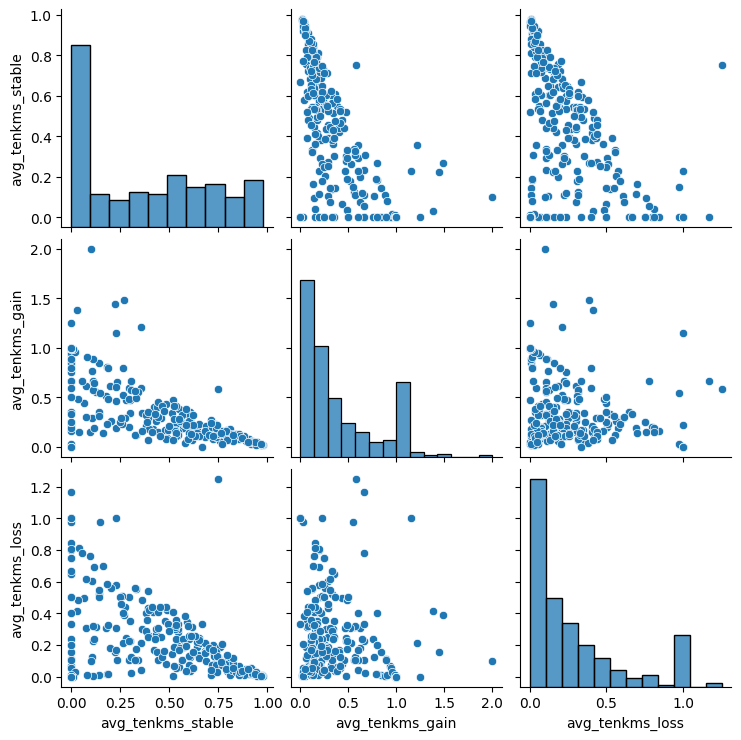

In [175]:
# Pairplot (useless?)
sample = sklearn.utils.resample(dist_means, n_samples=10)
sns.pairplot(dist_means.query("interval == '1990-2010'")[["avg_tenkms_stable", "avg_tenkms_gain", "avg_tenkms_loss"]])

### Readying labelled data for machine learning classifiers

In [177]:
cons_labels = conservation_status[["speccode", "status"]]
cons_labels = cons_labels[cons_labels["speccode"].isin(dist_means["speccode"])]
cons_labels

,speccode,status
0,1,g
1,2,a
2,3,a
5,6,g
6,7,g
...,...,...
448,1563,g
449,1569,g
452,1578,g
453,1579,g


In [182]:
dist_means_labelled = dist_means.merge(right=cons_labels, on="speccode")
dist_means_labelled

,speccode,interval,avg_tenkms_stable,avg_tenkms_gain,avg_tenkms_loss,status
0,1,1970-1990,0.630485,0.267898,0.101617,g
1,1,1990-2010,0.599138,0.161638,0.239224,g
2,2,1970-1990,0.512821,0.223443,0.263736,a
3,2,1990-2010,0.540441,0.261029,0.198529,a
4,3,1970-1990,0.016129,0.870968,0.112903,a
...,...,...,...,...,...,...
583,1563,1970-1990,0.000000,0.000000,1.000000,g
584,1569,1970-1990,0.000000,0.000000,1.000000,g
585,1578,1970-1990,0.000000,0.000000,1.000000,g
586,1579,1970-1990,0.000000,0.000000,1.000000,g


### Quick auto-assessment of various machine learning techniques

In [196]:
X = np.array(dist_means_labelled.query("interval == '1990-2010'")["avg_tenkms_loss"])
y = np.array(dist_means_labelled.query("interval == '1990-2010'")["status"])
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=.3)
clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(X_train, X_test, y_train, y_test)
display(models)

  0%|          | 0/29 [00:00<?, ?it/s]

 31%|███       | 9/29 [00:00<00:00, 33.79it/s]/home/sam/Documents/University/Year 3/ECM3420 Learning from Data/Birds/.venv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
100%|██████████| 29/29 [00:00<00:00, 48.02it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000053 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 58
[LightGBM] [Info] Number of data points in the train set: 219, number of used features: 1
[LightGBM] [Info] Start training from score -1.278198
[LightGBM] [Info] Start training from score -3.779634
[LightGBM] [Info] Start training from score -0.735111
[LightGBM] [Info] Start training from score -1.517871
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positi

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
NearestCentroid,0.38,0.49,None,0.37,0.01
SVC,0.56,0.40,None,0.54,0.01
LabelPropagation,0.54,0.39,None,0.50,0.01
LabelSpreading,0.54,0.39,None,0.50,0.01
BernoulliNB,0.49,0.38,None,0.39,0.01
ExtraTreesClassifier,0.50,0.36,None,0.49,0.07
KNeighborsClassifier,0.47,0.36,None,0.47,0.01
RandomForestClassifier,0.49,0.36,None,0.48,0.10
DecisionTreeClassifier,0.49,0.36,None,0.48,0.01


In [195]:
X = np.array(dist_means_labelled.query("interval == '1990-2010'")["avg_tenkms_gain"])
y = np.array(dist_means_labelled.query("interval == '1990-2010'")["status"])
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=.3)
clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(X_train, X_test, y_train, y_test)
display(models)

  0%|          | 0/29 [00:00<?, ?it/s]

  3%|▎         | 1/29 [00:00<00:02,  9.51it/s]/home/sam/Documents/University/Year 3/ECM3420 Learning from Data/Birds/.venv/lib/python3.10/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
 31%|███       | 9/29 [00:00<00:00, 30.37it/s]/home/sam/Documents/University/Year 3/ECM3420 Learning from Data/Birds/.venv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
100%|██████████| 29/29 [00:00<00:00, 43.86it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000048 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60
[LightGBM] [Info] Number of data points in the train set: 219, number of used features: 1
[LightGBM] [Info] Start training from score -1.140576
[LightGBM] [Info] Start training from score -4.002777
[LightGBM] [Info] Start training from score -0.735111
[LightGBM] [Info] Start training from score -1.700192
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positi

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
PassiveAggressiveClassifier,0.44,0.35,None,0.43,0.01
ExtraTreeClassifier,0.49,0.34,None,0.47,0.01
BaggingClassifier,0.50,0.34,None,0.46,0.04
DecisionTreeClassifier,0.49,0.33,None,0.44,0.01
RandomForestClassifier,0.49,0.33,None,0.44,0.10
ExtraTreesClassifier,0.48,0.32,None,0.43,0.08
GaussianNB,0.45,0.32,None,0.42,0.01
QuadraticDiscriminantAnalysis,0.45,0.32,None,0.42,0.01
LabelPropagation,0.46,0.32,None,0.45,0.01


In [194]:
X = np.array(dist_means_labelled.query("interval == '1990-2010'")["avg_tenkms_stable"])
y = np.array(dist_means_labelled.query("interval == '1990-2010'")["status"])
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=.3)
clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(X_train, X_test, y_train, y_test)
display(models)

 31%|███       | 9/29 [00:00<00:00, 35.23it/s]/home/sam/Documents/University/Year 3/ECM3420 Learning from Data/Birds/.venv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/sam/Documents/University/Year 3/ECM3420 Learning from Data/Birds/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
100%|██████████| 29/29 [00:00<00:00, 49.80it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000041 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 53
[LightGBM] [Info] Number of data points in the train set: 219, number of used features: 1
[LightGBM] [Info] Start training from score -1.169564
[LightGBM] [Info] Start training from score -3.597312
[LightGBM] [Info] Start training from score -0.793952
[LightGBM] [Info] Start training from score -1.560430
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positi

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
SGDClassifier,0.51,0.50,None,0.51,0.01
SVC,0.57,0.46,None,0.49,0.01
LGBMClassifier,0.56,0.45,None,0.52,0.06
DecisionTreeClassifier,0.52,0.44,None,0.50,0.01
RandomForestClassifier,0.52,0.44,None,0.50,0.10
BaggingClassifier,0.51,0.43,None,0.49,0.02
ExtraTreesClassifier,0.51,0.42,None,0.49,0.08
LabelSpreading,0.55,0.41,None,0.46,0.01
ExtraTreeClassifier,0.50,0.41,None,0.48,0.01


### Neural Network approach

In [3]:
model = keras.Sequential(
    [
        layers.Dense(units=8, activation="relu", input_shape=(6,)),
        layers.Dense(units=8, activation="relu"),
        layers.Dense(units=4, activation="sigmoid")
    ]
)